In [16]:
import cupy as cp
import cupyx as cpx
from matplotlib import pyplot as plt
import networkx as nx


In [27]:
def distance_matrix(a, b):
    a2 = cp.sum(a*a, axis=1)
    b2 = cp.sum(b*b, axis=1)
    ab = cp.dot(a, b.T)
    dists = cp.sqrt(a2[:, None] - 2*ab + b2[None, :])
    return dists



class Individual:
    def __init__(self, initial_position, waiting_time_dist, step_size_dist):
        self.ini_position = cp.array(initial_position)
        self.waiting_time_hist = waiting_time_dist[0]/cp.sum(waiting_time_dist[0])
        self.waiting_time_edges = (waiting_time_dist[1][:-1]+waiting_time_dist[1][1:])/2
        self.waiting_time_mean =  cp.sum(self.waiting_time_edges * self.waiting_time_hist)
        self.step_size_hist = step_size_dist[0]/cp.sum(step_size_dist[0])
        self.step_size_edges = (step_size_dist[1][:-1]+step_size_dist[1][1:])/2
        self.time = 0
        self.positions= [self.ini_position]


    def generate_waiting_time(self,size_=1):
        # Generate a random waiting time based on the waiting_time_dist
        # Replace the function below with your desired waiting time distribution function
        return cp.random.choice(self.waiting_time_edges,size=size_, p=self.waiting_time_hist)

    def generate_step_size(self,size_=1):
        # Generate a random step size based on the step_size_dist
        # Replace the function below with your desired step size distribution function
        return cp.random.choice(self.step_size_edges,size=size_, p=self.step_size_hist)

    def move(self,time):
        # Generate a random direction
        positions= cp.zeros((2,time))
        # get mean of waiting time distribution 
        posible_size_w_t = int(2*time/self.waiting_time_mean)  
        waiting_time= self.generate_waiting_time(size_=posible_size_w_t)                                              
        while cp.sum(waiting_time)<=time: 
            waiting_time = cp.hstack((waiting_time,self.generate_waiting_time(size_=posible_size_w_t)))
        cumulative_sum = cp.cumsum(waiting_time)
        index = cp.where(cumulative_sum > time)[0][0]
        filtered_waiting_time = waiting_time[:index]
        step_size = self.generate_step_size(size_=len(filtered_waiting_time))
        theta = cp.random.uniform(0, 2 * cp.pi,size=len(filtered_waiting_time))
        direction = [cp.cos(theta), cp.sin(theta)]
        # Update position based on this simple model where individual stays still for each waiting time (updating positions with the actual position) and when the waiting time finishes move with step size in direction. 
        filtered_waiting_time = filtered_waiting_time.astype(int)
        # check if it has 0 in the waiting time 
                
        filtered_waiting_time[filtered_waiting_time == 0] += 1
        # Generate movements for each waiting time
        movements = step_size[:, cp.newaxis] * cp.array(direction).T
        # Repeat each movement for the corresponding waiting time
        repeated_movements = cp.repeat(movements, filtered_waiting_time.tolist(), axis=0)
        # add initial position to repeated_movements
        repeated_movements = cp.vstack((self.ini_position,repeated_movements))
        # Calculate positions
        positions = cp.cumsum(repeated_movements, axis=0)[:time]
        # Update positions
        self.positions=positions    


## Ensemble of individuals
class Ensemble:
    def __init__(self, n, initial_positions, waiting_time_dist, step_size_dist):
        self.n = n
        self.individuals = []
        for i in range(n):
            self.individuals.append(Individual(initial_positions[i], waiting_time_dist, step_size_dist))

    def move(self, time):
        for i in range(self.n):
            self.individuals[i].move(time)

    #need to change this function to gpu or something 
    def find_intersections(self, t0, x0):
        positions = cp.array([ind.positions for ind in self.individuals])
        n_individuals, time, _ = positions.shape
        intersections = []
        for i in range(n_individuals):
            for j in range(i+1, n_individuals):
                # Find the time indices where the individuals are close to each other
                dist = distance_matrix(positions[i], positions[j])
                close_indices = cp.where((dist < x0) & (cp.abs(cp.subtract.outer(cp.arange(time), cp.arange(time))) < t0))
                if len(close_indices[0]) > 0:
                    # Add the intersection times and the individual indices to the list of intersections
                    intersection_times_i = close_indices[0]
                    intersection_times_j = close_indices[1]
                    for k in range(len(intersection_times_i)):
                        intersections.append((i, j, intersection_times_i[k], intersection_times_j[k]))
        return intersections
      
    def plot(self,plot_intesections=True,intersections=[]):
        fig, ax = plt.subplots()
        for i in range(self.n):
            ax.plot(self.individuals[i].positions[:, 0].get(), self.individuals[i].positions[:, 1].get(), 'o-')
        for i, j, time1,time2 in intersections:

            # plot a line from individual i to individual j
            ax.plot([self.individuals[i].positions[time1, 0], self.individuals[j].positions[time2, 0]],[self.individuals[i].positions[time1, 1], self.individuals[j].positions[time2, 1]], 'k--')        
        plt.show()

    def plot_network(self, intersections):
        # Create a graph with the individuals as nodes
        G = nx.Graph()
        for i in range(self.n):
            G.add_node(i)
        # Add the intersections as edges
        for i, j, _, _ in intersections:
            G.add_edge(i, j)
        # Plot the graph
        nx.draw(G, node_size=100)
        plt.show()


    




In [43]:
# Generate random numbers from an exponential distribution
data = cp.random.exponential(scale=1.0, size=1000)
# Create a histogram of the data
hist, bin_edges = cp.histogram(data, bins=10, density=True)
#ind = Individual(initial_position=[0,0],waiting_time_dist=[hist,bin_edges],step_size_dist=[hist,bin_edges])
time = 2*60
#ind.move(time=time)
n_ind= 50000
initial_positions= cp.zeros((n_ind,2))

population= Ensemble(n_ind,initial_positions,waiting_time_dist=[hist,bin_edges],step_size_dist=[hist,bin_edges])
start_gpu = cp.cuda.Event()
start_gpu.record()
population.move(time)
end_gpu = cp.cuda.Event()
end_gpu.record()

In [45]:
t_gpu = cp.cuda.get_elapsed_time(start_gpu, end_gpu)
print(t_gpu)

123046.515625


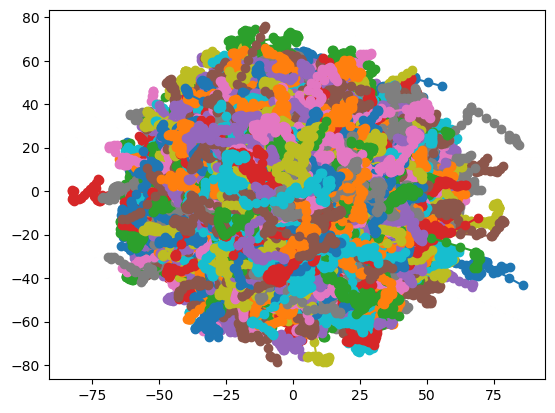

In [46]:
#intersections= population.find_intersections(t0=5,x0=2)
population.plot(plot_intesections=False)
#population.plot_network(intersections)